In [64]:
import os
import random
import matplotlib.pyplot as plt
from torch import nn
from glob import glob
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torchmetrics import Accuracy, ConfusionMatrix
from tqdm.auto import tqdm
import torch
import numpy as np
from PIL import Image
from typing import List, Dict
import pandas as pd

In [65]:
# get device gpu
dev = "cuda" if torch.cuda.is_available() else "cpu"

# check files
path = "./data/pizza_steak_sushi/"
def walk_through_dir(path):
    for dirpath, dirnames, filesnames in os.walk(path):
        print(f"There are {len(dirnames)} directories {len(filesnames)} images {dirpath}")

walk_through_dir(path)

There are 2 directories 0 images ./data/pizza_steak_sushi/
There are 3 directories 0 images ./data/pizza_steak_sushi/test
There are 0 directories 25 images ./data/pizza_steak_sushi/test/pizza
There are 0 directories 19 images ./data/pizza_steak_sushi/test/steak
There are 0 directories 31 images ./data/pizza_steak_sushi/test/sushi
There are 3 directories 0 images ./data/pizza_steak_sushi/train
There are 0 directories 78 images ./data/pizza_steak_sushi/train/pizza
There are 0 directories 75 images ./data/pizza_steak_sushi/train/steak
There are 0 directories 72 images ./data/pizza_steak_sushi/train/sushi


Random image path: pizza
Image class: test
Image shape (384, 512, 3)


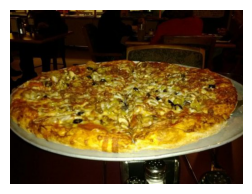

In [66]:
# get all images
image_path_list = list(glob(path +"*/*/*.jpg"))

# pick a random image
random_image_path = random.choice(image_path_list)

# parent file and parent image
parent = os.path.dirname(random_image_path)

# open image 
img = Image.open(random_image_path)

# view with plt
img_plt = np.asarray(img)
plt.figure(figsize=(3,3))
plt.imshow(img_plt)
print(f"Random image path: {parent.split('/')[4]}")
print(f"Image class: {parent.split('/')[3]}")
print(f"Image shape {img_plt.shape}")
plt.axis(False);

In [67]:
# transformin data
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

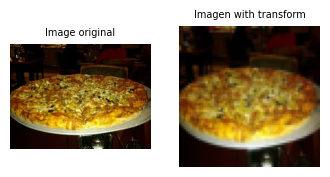

In [68]:
# Visualize image original and image transform
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image original", size=7)
plt.axis(False);

plt.subplot(1,2,2)
plt.imshow(train_transform(img).permute(1,2,0))
plt.title("Imagen with transform", size=7)
plt.axis(False);

In [69]:
# seput train and test path
train_dir = "./data/pizza_steak_sushi/train"
test_dir = "./data/pizza_steak_sushi/test/"

# Use ImageFolder to create dataset
train_data = ImageFolder(root=train_dir, transform=train_transform, target_transform=None)
test_data = ImageFolder(root=test_dir, transform=test_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: ./data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: ./data/pizza_steak_sushi/test/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [70]:
len(train_data), len(test_data)

(225, 75)

In [71]:
# Create TinyVGG model class
class TinyVGG(nn.Module):
    def __init__(self, input, output, hidden) :
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*16*16, out_features=output)
        )
    def forward(self, x):
        return self.block_3(self.block_2(self.block_1(x)))

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input=3, output=len(train_data.classes), hidden=10).to(dev)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [72]:
model_summary = summary(model=model_0, input_size=(3,3,64,64)) # values original
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [3, 3]                    --
├─Sequential: 1-1                        [3, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [3, 10, 64, 64]           280
│    └─ReLU: 2-2                         [3, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [3, 10, 64, 64]           910
│    └─ReLU: 2-4                         [3, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [3, 10, 32, 32]           --
├─Sequential: 1-2                        [3, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [3, 10, 32, 32]           910
│    └─ReLU: 2-7                         [3, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [3, 10, 32, 32]           910
│    └─ReLU: 2-9                         [3, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [3, 10, 16, 16]           --
├─Sequentia

In [73]:
# turn loaded images into Dataloader
BATCH_SIZE = 3
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                              num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                             num_workers=1, shuffle=False)

len(train_dataloader), len(test_dataloader)

(75, 25)

In [74]:
# loss, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
acc_fn = Accuracy("multiclass", num_classes=len(train_data.classes)).to(dev)

In [75]:
# train step
def train_step(model:nn.Module, dataloader:DataLoader, loss_fn:nn.Module,
               optimizer, acc_fn,dev:torch.device=dev):
    
    train_loss, train_acc = 0,0
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        
        x,y = x.to(dev), y.to(dev)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # train_pred_labels = y_pred.argmax(dim=1)
        # train_acc += ((train_pred_labels == y).sum().item()/len(train_pred_labels))
        train_acc += acc_fn(y, y_pred.argmax(dim=1)).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc
    
def test_step(model:nn.Module, dataloader:DataLoader, loss_fn:nn.Module, acc_fn,
              dev:torch.device=dev):
    
    test_loss, test_acc = 0,0

    model.eval()
    with torch.inference_mode():
        for batch, (x,y) in enumerate (dataloader):
            
            x,y = x.to(dev), y.to(dev)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            # test_pred_labels = y_pred.argmax(dim=1)
            # test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            test_acc += acc_fn(y, y_pred.argmax(dim=1)).item()
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [76]:

# 1. Take in various parameters required for training and test steps
def train(model: nn.Module, train_dataloader: DataLoader, 
          test_dataloader: DataLoader, optimizer, loss_fn, acc_fn, epochs):
    
    results = {"train_loss": [], "train_acc": [], "test_loss": [],
               "test_acc": [] }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn, acc_fn=acc_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, 
                                        loss_fn=loss_fn, acc_fn=acc_fn)
        
        print( f"Epoch: {epoch+1} | "
               f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
               f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}" )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [86]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0_results = train(model=model_0,  train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader, optimizer=optimizer,
                        loss_fn=loss_fn, epochs=NUM_EPOCHS, acc_fn=acc_fn)

 20%|██        | 1/5 [00:01<00:04,  1.03s/it]

Epoch: 1 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1008 | test_acc: 0.2533


 40%|████      | 2/5 [00:02<00:03,  1.01s/it]

Epoch: 2 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1008 | test_acc: 0.2533


 60%|██████    | 3/5 [00:03<00:02,  1.02s/it]

Epoch: 3 | train_loss: 1.0982 | train_acc: 0.3911 | test_loss: 1.1010 | test_acc: 0.3067


 80%|████████  | 4/5 [00:04<00:01,  1.01s/it]

Epoch: 4 | train_loss: 1.0977 | train_acc: 0.3822 | test_loss: 1.1017 | test_acc: 0.3467


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

Epoch: 5 | train_loss: 1.0975 | train_acc: 0.3467 | test_loss: 1.1020 | test_acc: 0.3333


In [87]:
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.098547,0.333333,1.100803,0.253333
1,1.098374,0.333333,1.100824,0.253333
2,1.098189,0.391111,1.101022,0.306667
3,1.097696,0.382222,1.101655,0.346667
4,1.097511,0.346667,1.102015,0.333333


## Create model 1

In [88]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# turn loaded images into Dataloader
BATCH_SIZE = 5
train_1_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                              num_workers=1, shuffle=True)
test_1_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                             num_workers=1, shuffle=False)

# loss, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001)
acc_fn = Accuracy("multiclass", num_classes=len(train_data.classes)).to(dev)

NUM_EPOCHS = 5

model_1 = TinyVGG(input=3, output=len(train_data.classes), hidden=15).to(dev)

model_1_results = train(model=model_1,  train_dataloader=train_1_dataloader,
                        test_dataloader=test_1_dataloader, optimizer=optimizer,
                        loss_fn=loss_fn, epochs=NUM_EPOCHS, acc_fn=acc_fn)

 20%|██        | 1/5 [00:01<00:04,  1.04s/it]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3467 | test_loss: 1.0978 | test_acc: 0.3333


 40%|████      | 2/5 [00:02<00:03,  1.00s/it]

Epoch: 2 | train_loss: 1.0983 | train_acc: 0.3467 | test_loss: 1.0978 | test_acc: 0.3333


 60%|██████    | 3/5 [00:03<00:02,  1.01s/it]

Epoch: 3 | train_loss: 1.0984 | train_acc: 0.3467 | test_loss: 1.0978 | test_acc: 0.3333


 80%|████████  | 4/5 [00:04<00:01,  1.01s/it]

Epoch: 4 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.0978 | test_acc: 0.3333


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

Epoch: 5 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.0978 | test_acc: 0.3333


In [89]:
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.098406,0.346667,1.097817,0.333333
1,1.098311,0.346667,1.097817,0.333333
2,1.098370,0.346667,1.097817,0.333333
3,1.098528,0.346667,1.097817,0.333333
4,1.098475,0.346667,1.097817,0.333333


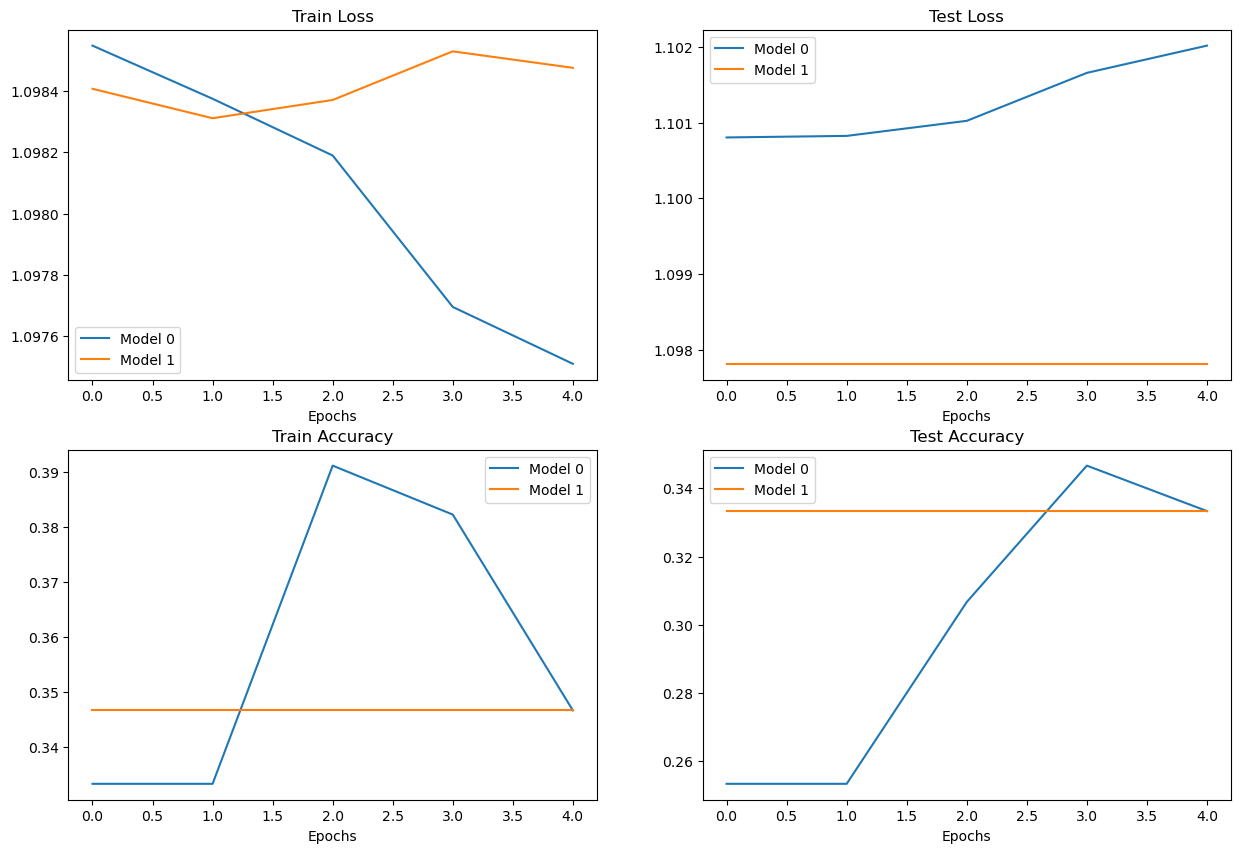

In [91]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [81]:
model_1_df["train_loss"]

0    1.098406
1    1.098311
2    1.098370
3    1.098528
4    1.098475
Name: train_loss, dtype: float64